- Notebook based on "hunspell_analysis_public.ipynb", copied and modified

# Analysis: Nuspells' spelling correction on litkey data set
Preface: This notebook is going to analyse the results of the evaluation of Nuspell on the litkey data set. Therefore, the evaluation results, created in _postprocessing_run_complete_default_config_ notebook, are loaded into this notebook at first (see section 1). Afterwards, the evaluation results are going to be explored (see section 2-4).

## Outline
0. [Preparation](#0)
    - Imports
    - Configuration
1. [Load data sets](#1)
    - Types & token, case insensitive & case sensitive
    - Explanantion of (new) variables
2. **[Types & Tokens Stats](#2)**
    - Upper bound value
    - Bar charts
    - Ratio
3. [Distribution (token base):](#3)
    - [**Per Nuspell suggestions**](#5)
    - Per testpoint (_same to hunspell, corpus stat_)
    
4. [Relationships:](#4) 

    - Suggestions index on test point
        - Percent stacked bar plot
        - [**Percent stacked bar plot, 3 categories**](#6)
    - Levenshtein distance on testpoint (_same to hunspell, corpus stat_)
        - Percent stacked bar plot
    - Suggestions index on Levenshtein distance
        - [**Percent stacked bar plot**](#7)

<a id='0'></a><br>
## 0 - Preparation

In [1]:
# IMPORTS
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import numpy as np
# Sets backend to the 'inline' backend; Helps with plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import sys 
sys.path.insert(0, './Experiments/Experiment_hunspell')

import helpers_hunspell_analysis as helpers

In [2]:
# Configuration for plots
# Set figure size for sns plot
%config InlineBackend.figure_format = 'retina'
mpl.rc('figure', figsize=(8, 6), dpi=100)
sns.set()
#sns.set_style('darkgrid')

# Do not truncate rows of DataFrame
pd.set_option('display.max_rows', None)
# Do not truncate column width
pd.set_option('display.max_colwidth', None)

<a id='1'></a><br>
## 1 - Load data sets
Four versions of the data set are reloaded from pickles. The evaluation has been already run in _postprocessing_run_complete_default_config_ notebook.
- type and token based case insensitive (no special ending in df name, i. e. _default_)
- type and token based case sensitive (_cs ending_ in df name) 


### Explanation of (new) variables
- Whether the target word is among the suggested words by hunspell (= _**'in_sugg'**_).
    - At which index it is among the suggested words by hunspell (= _**'sugg_index'**_).
- Whether the target word is ranked at index 0 by hunspell (= _**'idx0'**_).

In [3]:
# Load df from pickle
data_error_token = pd.read_pickle('./Experiments/Experiment_nuspell/data_error_token_nuspell_evaluation_lc.pkl')
data_error_types = pd.read_pickle('./Experiments/Experiment_nuspell/data_error_types_nuspell_evaluation_lc.pkl')

In [4]:
data_error_token_cs = pd.read_pickle('./Experiments/Experiment_nuspell/data_error_token_nuspell_evaluation_cs.pkl')
data_error_types_cs = pd.read_pickle('./Experiments/Experiment_nuspell/data_error_types_nuspell_evaluation_cs.pkl')

In [5]:
display(data_error_token.head(5))

,original,corrected,filename,freq_ori,freq_cor,freq_tup,unchanged_original,suggestions,in_sugg,sugg_idx,idx0
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,belt,"[lebt, bellt, bebt, welt, zelt, bettelt, betel]",True,1.0,False
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,kukt,"[kurt, bukt, kult]",False,NaN,False
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,dan,"[an, da, dann, dran, dank, den, das, ran, dar, man, van, san, jan, pan, fan, d an, da n]",True,2.0,False
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,gekricht,"[gekracht, gekreischt, gericht, gerichtet, gerichtlich]",False,NaN,False
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,leken,"[lenken, lecken, ekeln, lenke, lesen, legen, leben, lenken, lecken, keilen]",True,1.0,False


In [6]:
display(data_error_types.head(5))

,original,corrected,filename,freq_ori,freq_cor,freq_tup,unchanged_original,suggestions,in_sugg,sugg_idx,idx0
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,belt,"[lebt, bellt, bebt, welt, zelt, bettelt, betel]",True,1.0,False
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,kukt,"[kurt, bukt, kult]",False,NaN,False
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,dan,"[an, da, dann, dran, dank, den, das, ran, dar, man, van, san, jan, pan, fan, d an, da n]",True,2.0,False
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,gekricht,"[gekracht, gekreischt, gericht, gerichtet, gerichtlich]",False,NaN,False
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,leken,"[lenken, lecken, ekeln, lenke, lesen, legen, leben, lenken, lecken, keilen]",True,1.0,False


<a id='2'></a><br>
## 2 - Types & Tokens Stats

### Get upper bound information

In [7]:
# Values copied from hunspell_upper_bound notebook
# SINCE NUSPELL USES HUNSPELL DICTIONARY, same upper bound
# TODO: Do not hardcode
ub_types = 0.9242935470265711
ub_token = 0.9407341164993293

ub_types_ci = 0.9280894137494728
ub_token_ci = 0.9429291492215763

df_list = [data_error_types, data_error_token]

def get_ub(df, ub):
    ub_pct = round(ub*100, 2)
    ub_ttl = int(df.shape[0]*ub)
    return [ub, ub_pct, ub_ttl]

ub_types_list = get_ub(data_error_types, ub_types)
ub_token_list = get_ub(data_error_token, ub_token)

ub_types_ci_list = get_ub(data_error_types, ub_types_ci)
ub_token_ci_list = get_ub(data_error_token, ub_token_ci)

#for i in range(len(ub_types_list)):
#    print(ub_types_list[i])
#print('*'*20)
#for i in range(len(ub_token_list)):
#    print(ub_token_list[i])

### Get values for bar chart

In [8]:
# Get values for y axis
def get_values_bars(df):
    total = df.shape[0]
    in_sugg = df[df.in_sugg].shape[0]
    idx0 = df[df.idx0].shape[0]
    return [total, in_sugg, idx0]

values_types = get_values_bars(data_error_types)
values_token = get_values_bars(data_error_token)

values_types_cs = get_values_bars(data_error_types_cs)
values_token_cs = get_values_bars(data_error_token_cs) 

print('Types case insensitive')
for i in range(len(values_types)):
    print(values_types[i])
print('*'*20)

print('Token case insensitive')
for i in range(len(values_token)):
    print(values_token[i])
print('*'*20)

print('Types CASE SENSITIVE')
for i in range(len(values_types_cs)):
    print(values_types_cs[i])
print('*'*20)

print('Token CASE SENSITIVE')
for i in range(len(values_token_cs)):
    print(values_token_cs[i])

Types case insensitive
9484
5566
3402
********************
Token case insensitive
24601
15714
8593
********************
Types CASE SENSITIVE
9484
5079
3180
********************
Token CASE SENSITIVE
24601
14973
8282


In [9]:
# Put everything together in lists
# define x axis POSITIONS
x_pos = [[0,1,2], [0,1,2], [0,1,2], [0,1,2]] #plot 0, plot 1, plot 3, plot 4

# put y axis VALUES together, see above
y_val = [values_types, values_token, values_types_cs, values_token_cs] #plot 0, plot 1, plot 3, plot 4

# put upper bound values together, see above
ub_list = [ub_types_ci_list, ub_token_ci_list, ub_types_list, ub_token_list]

x_y_plots = zip(x_pos, y_val)

### Bar charts

In [10]:
# TODO: Outsource

def loop_plot(plots, ub_list):
    
        # Plot everythin in one figure
        fig = plt.figure(figsize=(8,8))
        
        # Use dict to have more control
        axs = {}
        # Counter for position of subplot, third argument
        e = 1
        
        # loop over 'plots', i. e. 1 list containing 4 tuples (idx 0,1,2,3);
        # each tuple containing 2 lists (x and y values)
        
        # control overall plot via 'idx', set axes
            # idx is no. of plot
        # control content of plot via 'value'
        
        for idx, value in enumerate(plots):
        #for idx, (x, y) in enumerate(zip(x_pos, y_vals)):
            
            # Add axes subplot
            axs[idx] = fig.add_subplot(2,2,e)
       
            # Create bars
            # value[0] is position x axis, value[1] position y axis (value count)
            axs[idx].bar(value[0], value[1])

            
            # CONFIQ that stays same
            
            # Names of groups and bar width
            names = ['all errors','in suggestions','first suggestion']
            barWidth = 1

            # Custom x axis
            axs[idx].set_xticks(value[0])
            axs[idx].set_xticklabels(names, rotation=20)
            axs[idx].set_ylabel('count')

            # Baseline plot
            # Use idx of loop to control ub_list also
            axs[idx].axhline(ub_list[idx][2], ls='-', color='r') # access total value
            axs[idx].text(2, ub_list[idx][2]+(value[1][0]/50), str(ub_list[idx][1])+'%', color='r', weight='bold', style='italic') # x,y ; Access pct value
            axs[idx].text(2, ub_list[idx][2]-(value[1][0]/12.5), '('+str(ub_list[idx][2])+')')
            
            # Text for bar plots (total, pct)
            pct_bars = [100, round(value[1][1]/value[1][0]*100,2), round(value[1][2]/value[1][0]*100,2)] # all, in sugg, index 0
            for idx2, value2 in enumerate(value[1]): # loop over y positions
                # total
                axs[idx].text(idx2-0.275, value2-(value[1][0]*0.1), '('+str(value2)+')') # x, y
                # percent
                axs[idx].text(idx2-0.275, value2, str(pct_bars[idx2])+'%', color='grey', weight='bold', style='italic')
            
            e+=1
        
        return fig, axs

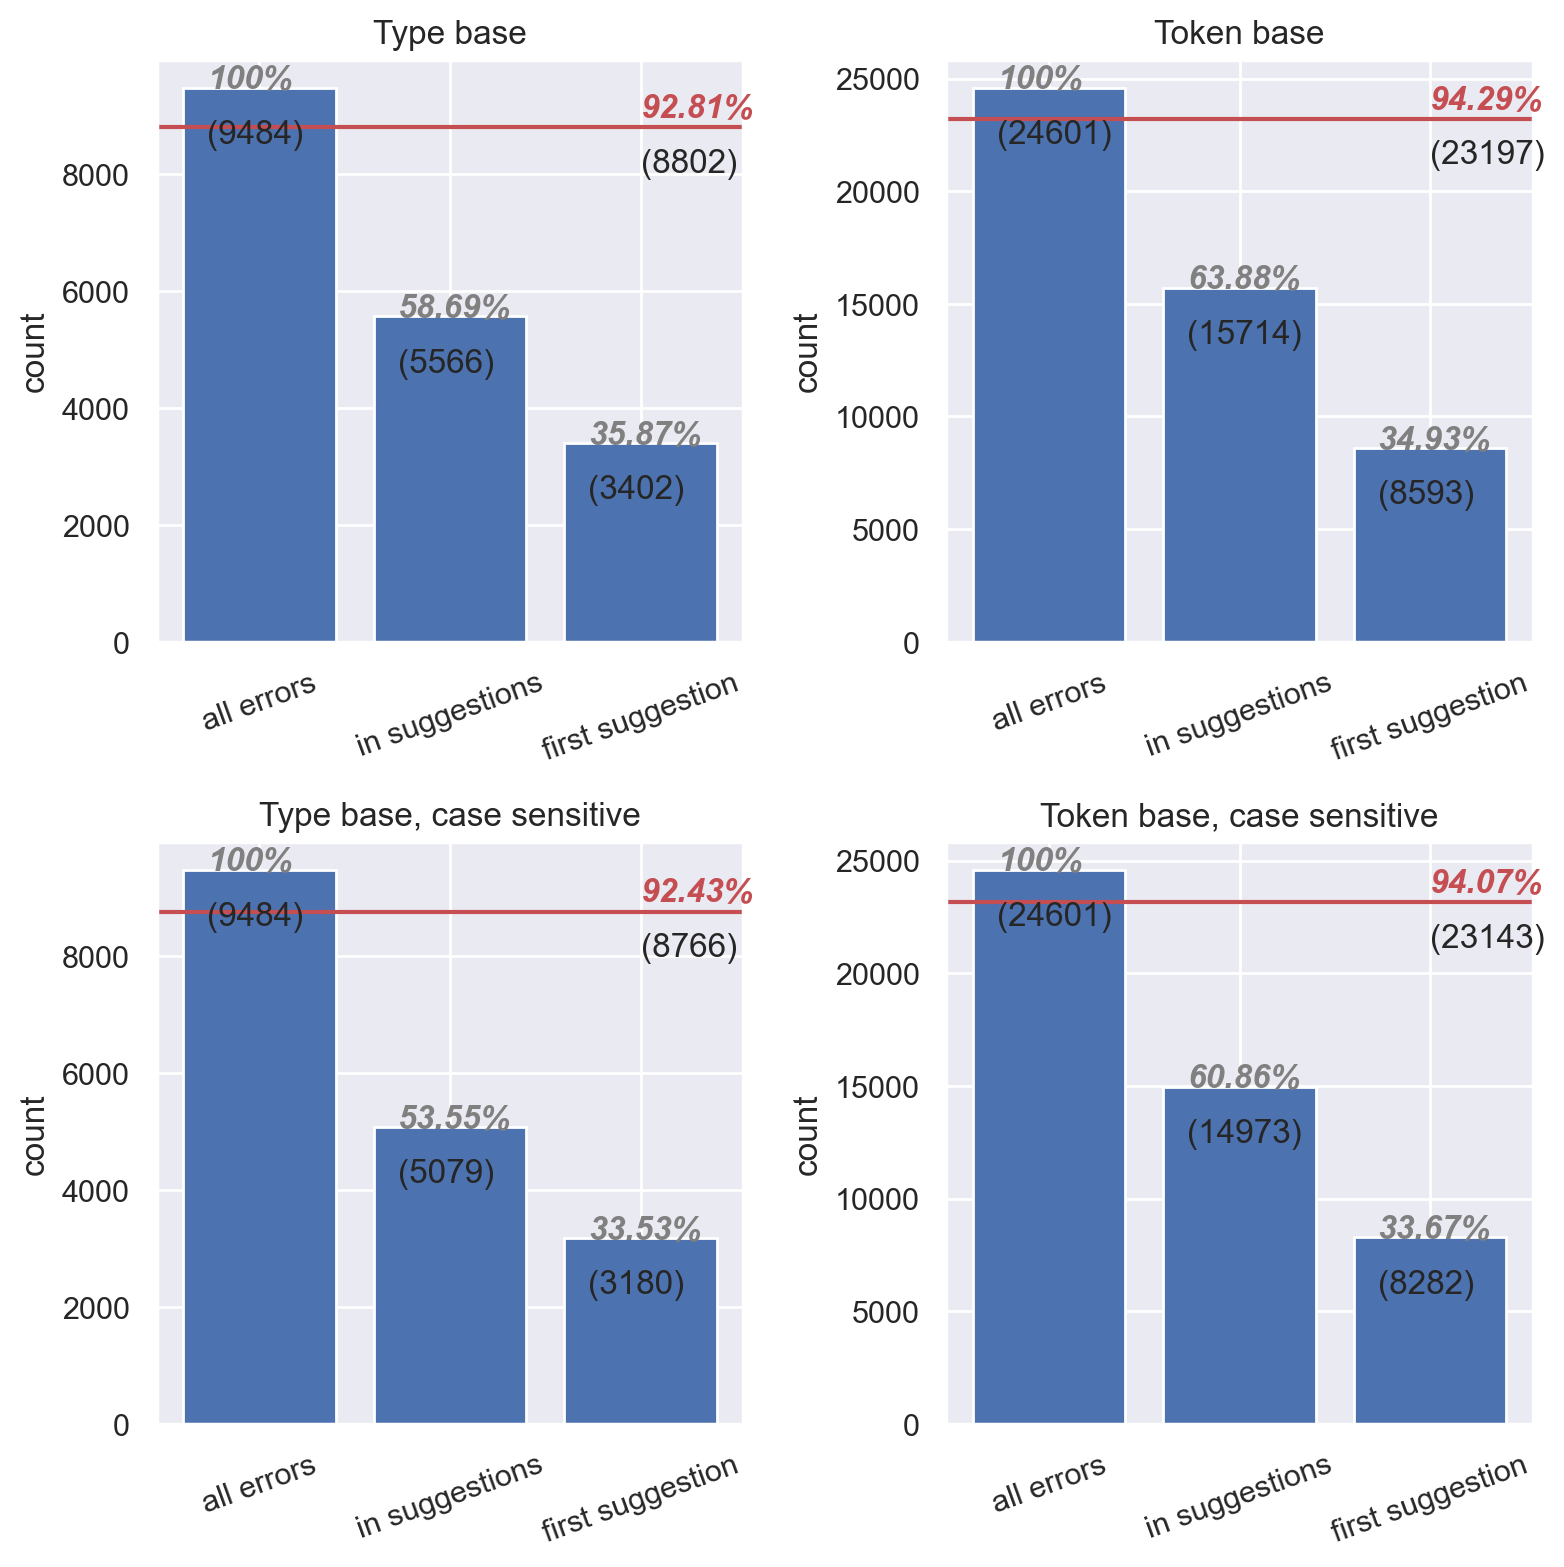

In [11]:
fig, axs = loop_plot(x_y_plots, ub_list)

# CONFIQ for each plot each

axs[0].set_title("Type base")
axs[1].set_title("Token base")

axs[2].set_title("Type base, case sensitive")
axs[3].set_title("Token base, case sensitive")

#plt.set_title("Spelling correction by hunspell (TYPE base)", fontweight='bold')
plt.tight_layout()
plt.show()

### Ratios

In [12]:
display(values_token[2]/values_token[0]) # first_sugg/all_token
display(values_token[2]/values_token[1]) # first_sugg/in_sugg

0.34929474411609285

0.5468372152220949

<a id='3'></a><br>
## 3 - Distributions (token base)
- Per Nuspell suggestions (indices)
- Per testpoint

In [13]:
# PREPARATION
# How often is it not in suggestions at all? dummy index -1
data_error_token['sugg_idx'].fillna(-1, inplace=True)
data_error_types['sugg_idx'].fillna(-1, inplace=True)

In [14]:
display(data_error_token.sugg_idx.value_counts().sort_values(ascending=False))
display(data_error_types.sugg_idx.value_counts().sort_values(ascending=False))

-1.0     8887
 0.0     8593
 1.0     2800
 2.0     1751
 3.0     1002
 5.0      364
 4.0      304
 6.0      248
 11.0     213
 7.0      154
 9.0       82
 8.0       76
 10.0      53
 13.0      24
 12.0      23
 14.0      15
 15.0       6
 17.0       3
 18.0       2
 16.0       1
Name: sugg_idx, dtype: int64

-1.0     3918
 0.0     3402
 1.0      973
 2.0      432
 3.0      235
 4.0      128
 5.0      115
 6.0       93
 7.0       51
 8.0       35
 9.0       35
 11.0      15
 10.0      15
 13.0      10
 12.0      10
 14.0       9
 15.0       3
 18.0       2
 17.0       2
 16.0       1
Name: sugg_idx, dtype: int64

<a id='5'></a><br>
#### 1) Per Nuspell suggestions (indices)

In [16]:
#sns.countplot(data_error_types.dict_index)
#sns.countplot(data_error_types[data_error_types.possible].dict_index)

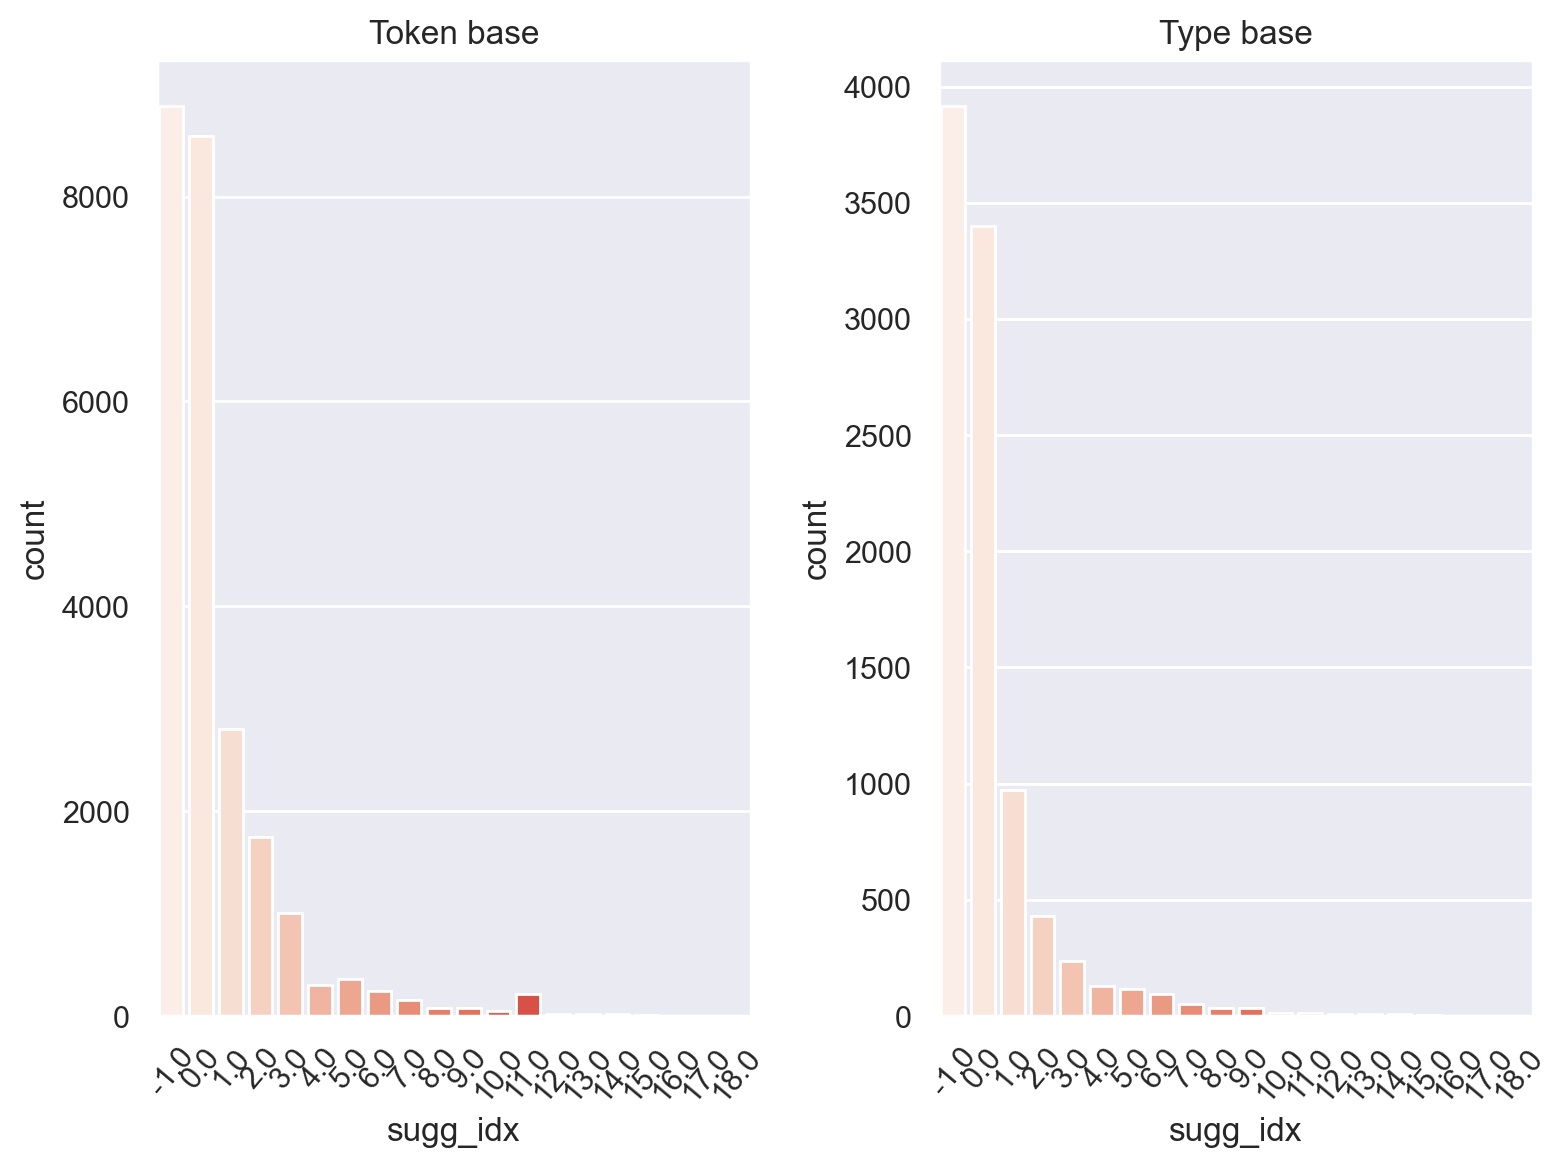

In [23]:
fig, axs = plt.subplots(1, 2)
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)

sns.countplot(x='sugg_idx', data=data_error_token, palette='Reds', ax=axs[0])
sns.countplot(x='sugg_idx', data=data_error_types,  palette='Reds', ax=axs[1])

axs[0].set_title('Token base')
axs[1].set_title('Type base')

# Labels are wrong this way; Gives back labels in the wrong order
#axs[0].set_xticklabels(labels=list(data_error_token.sugg_idx.unique()), rotation=50)
#axs[1].set_xticklabels(labels=list(data_error_types.sugg_idx.unique()), rotation=50)

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=50)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=50)

fig.tight_layout()

#### 2) Per testpoint

In [24]:
# test time point (01-10); It is firt number in filename
data_error_token['testpoint'] = data_error_token.filename.apply(lambda x: x.split('-')[0])

In [19]:
#sns.countplot(x='testpoint', data=data_error_token, palette="Blues")
#plt.show()

<a id='4'></a><br>
## 4 - Relationships

### Relationship: Suggestions index on testpoint
- Percent stacked bar plot
- Percent stacked bar plot, 3 categories


*Beforehand: <br>
Because there are so many indices of suggestions (0-14 and -1), values equal or above 5.0 are mapped to 5.0, so that there is a category ">= 5".*

In [25]:
# MAPPING
# Summarize values; 0, 1, 2, 3, 4, 5+
# Has to be mapped to one value, i. e. 5
        
def map_idx_5(x):
    sugg_idx = x['sugg_idx']
    #if sugg_idx in [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]:
    if sugg_idx in np.arange(5.0, max(data_error_token.sugg_idx)+1):
        return 5.0
    else:
        return sugg_idx
    
# Map categories and create new column for result
data_error_token['sugg_idx_5'] = data_error_token.apply(map_idx_5, axis=1)

#### 1) Percent stacked bar plot

In [28]:
# TODO: Modularize

# Get values: PERCENT STACKED BAR PLOT

# 1) Get counts for hue variable sugg_idx_5
def get_count_5(x, gb_var='testpoint'):
    return data_error_token[data_error_token.sugg_idx_5==x].groupby(gb_var).count().reset_index()

# 6
ct_non = get_count_5(-1)
ct_0 = get_count_5(0.0)
ct_1 = get_count_5(1.0)
ct_2 = get_count_5(2.0)
ct_3 = get_count_5(3.0)
ct_4 = get_count_5(4.0)
ct_5 = get_count_5(5.0)

In [29]:
# 2) Get totals, i. e. count for 100%
idx_5_total = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(ct_non['freq_ori'], ct_0['freq_ori'], ct_1['freq_ori'],
                                     ct_2['freq_ori'], ct_3['freq_ori'], ct_4['freq_ori'], ct_5['freq_ori'])] # list comprehension
display(idx_5_total)

[1716, 2154, 2028, 2520, 2527, 2924, 2900, 3046, 2549, 2237]

In [30]:
# 3) Get ratio of respective bars in percent, i. e. bar "length"
bars_ct_non = [i / j * 100 for i, j in zip(ct_non['freq_ori'], idx_5_total)]
bars_ct_0 = [i / j * 100 for i, j in zip(ct_0['freq_ori'], idx_5_total)]
bars_ct_1 = [i / j * 100 for i, j in zip(ct_1['freq_ori'], idx_5_total)]
bars_ct_2 = [i / j * 100 for i, j in zip(ct_2['freq_ori'], idx_5_total)]
bars_ct_3 = [i / j * 100 for i, j in zip(ct_3['freq_ori'], idx_5_total)]
bars_ct_4 = [i / j * 100 for i, j in zip(ct_4['freq_ori'], idx_5_total)]
bars_ct_5 = [i / j * 100 for i, j in zip(ct_5['freq_ori'], idx_5_total)]

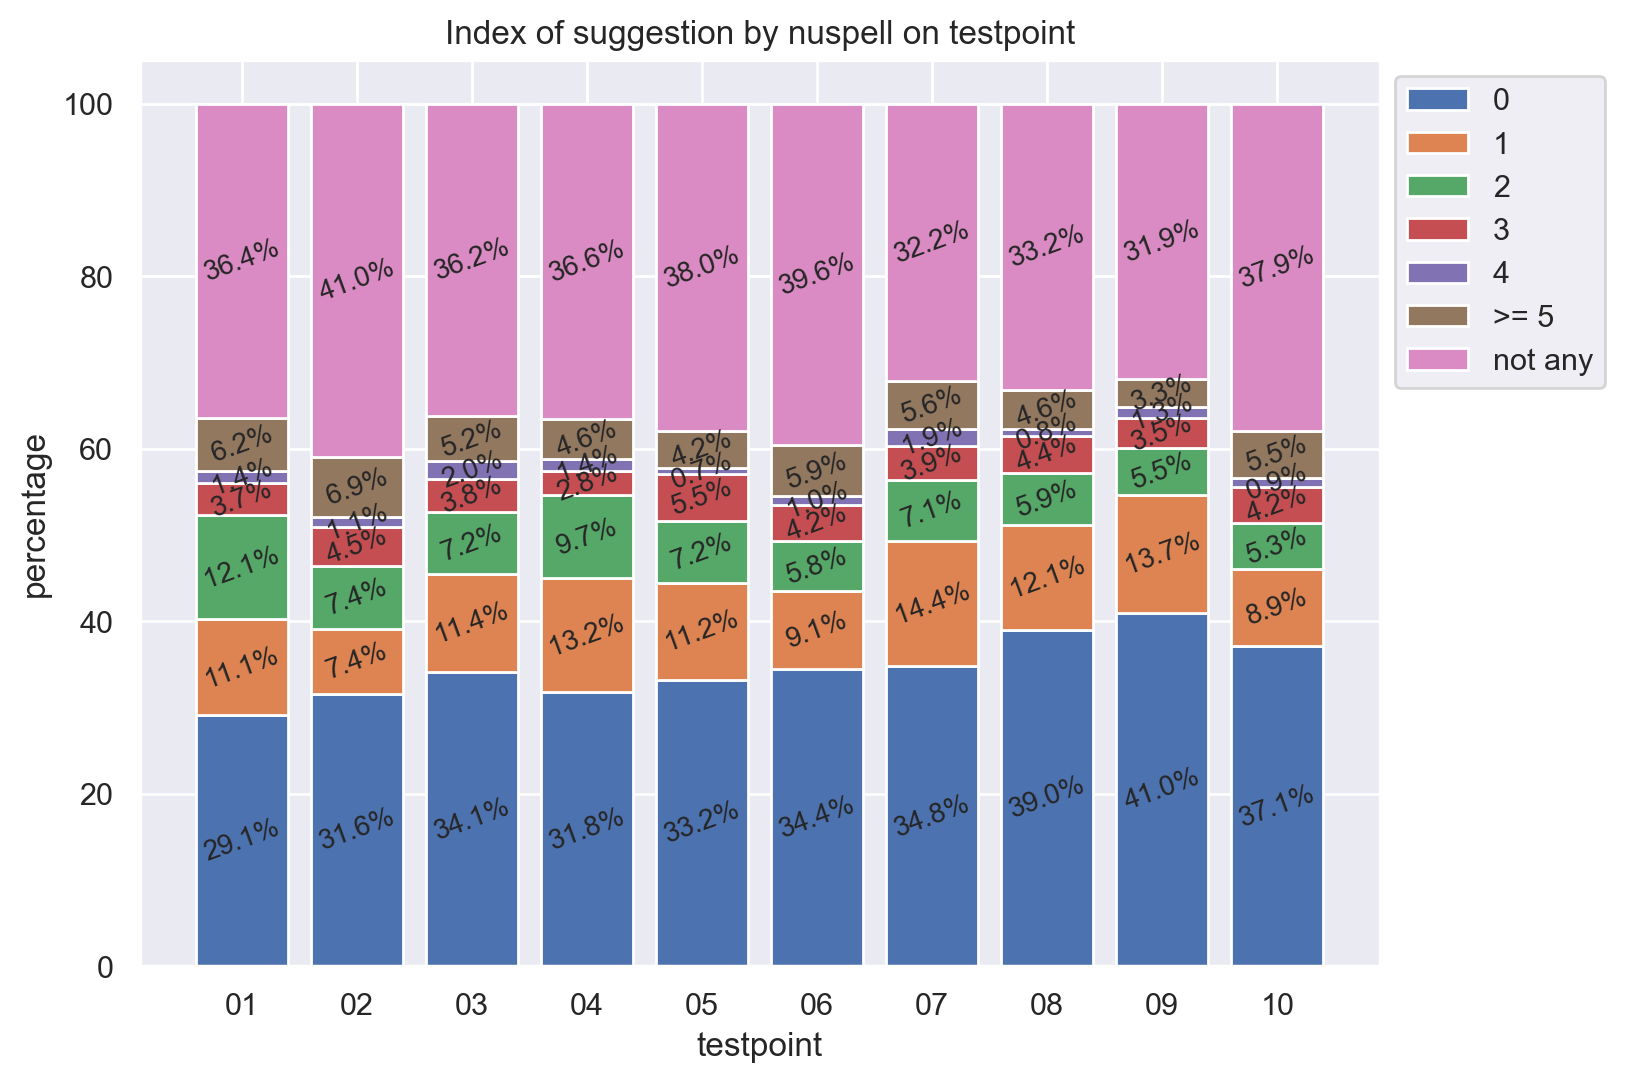

In [31]:
# TODO: Code schöner machen?!
# TODO: Percentages plotten...?
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = ct_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)
# Create bars
axs.bar(x_pos, bars_ct_0, bottom = 0, label='0') # index 0
axs.bar(x_pos, bars_ct_1, bottom=bars_ct_0, label='1') # index 1
axs.bar(x_pos, bars_ct_2, bottom=[i+j for i, j in zip(bars_ct_0,bars_ct_1)], label='2') 
axs.bar(x_pos, bars_ct_3, bottom=[i+j+k for i, j, k in zip(bars_ct_0,bars_ct_1, bars_ct_2)], label='3') 
axs.bar(x_pos, bars_ct_4, bottom=[i+j+k+l for i, j, k, l in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3)], label='4')
axs.bar(x_pos, bars_ct_5, bottom=[i+j+k+l+m for i, j, k, l, m in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4)], label='>= 5')
axs.bar(x_pos, bars_ct_non, bottom=[i+j+k+l+m+n for i, j, k, l, m, n in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)], label='not any')

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages
for idx, (ct_ttl, pct_non, pct_0, pct_1, pct_2, pct_3, pct_4, pct_5) in enumerate(zip(idx_5_total, bars_ct_non, bars_ct_0, bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)):
    axs.text(idx, bars_ct_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+(bars_ct_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+(bars_ct_2[idx]/2), str(round(pct_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+(bars_ct_3[idx]/2), str(round(pct_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+(bars_ct_4[idx]/2), str(round(pct_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+(bars_ct_5[idx]/2), str(round(pct_5,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+bars_ct_5[idx]+(bars_ct_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)

# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Index of suggestion by nuspell on testpoint')

plt.show()

<a id='6'></a><br>
#### 2) Percent stacked bar plot, 3 categories

In [53]:
# Per testpoint, count of error at index 0 in contrast to all other errors
# alle anderen
# sugg_idx nicht gefunden?! -1
def map_idx_bin(x):
    sugg_idx = x['sugg_idx']
    if sugg_idx == 0.0:
        return 0.0
    #elif sugg_idx in np.arange(1.0,15.0):
    elif sugg_idx in np.arange(1.0,max(data_error_token.sugg_idx)+1):
        return 1.0
    else:
        return sugg_idx

In [54]:
#np.arange(1.0,max(data_error_token.sugg_idx)+1)

In [55]:
# Map categories
data_error_token['sugg_idx_three'] = data_error_token.apply(map_idx_bin, axis=1)
data_error_types['sugg_idx_three'] = data_error_types.apply(map_idx_bin, axis=1)

In [56]:
# TODO: Modularize
# Count of error tokens, i. e. freq_ori, for each category (-1; 0; 1)
suggs_non = data_error_token[data_error_token.sugg_idx_three==-1].groupby('testpoint').count().reset_index() # returns index, not testpoint as index
#display(suggs_non)
suggs_0 = data_error_token[data_error_token.sugg_idx_three==0].groupby('testpoint').count().reset_index()
#display(suggs_0)
suggs_1 = data_error_token[data_error_token.sugg_idx_three==1].groupby('testpoint').count().reset_index()
#display(suggs_1)

In [57]:
# Get total, i. e. count for 100%
suggs_total = [i+j+k for i,j,k in zip(suggs_non['freq_ori'], suggs_0['freq_ori'], suggs_1['freq_ori'])] # list comprehension
#display(suggs_total)

# Get ratio of respective bars in percent, i. e. bar "length"
bars_sugg_non = [i / j * 100 for i, j in zip(suggs_non['freq_ori'], suggs_total)]
bars_sugg_0 = [i / j * 100 for i, j in zip(suggs_0['freq_ori'], suggs_total)]
bars_sugg_1 = [i / j * 100 for i, j in zip(suggs_1['freq_ori'], suggs_total)]
#display(bars_sugg_non, bars_sugg_0, bars_sugg_1)

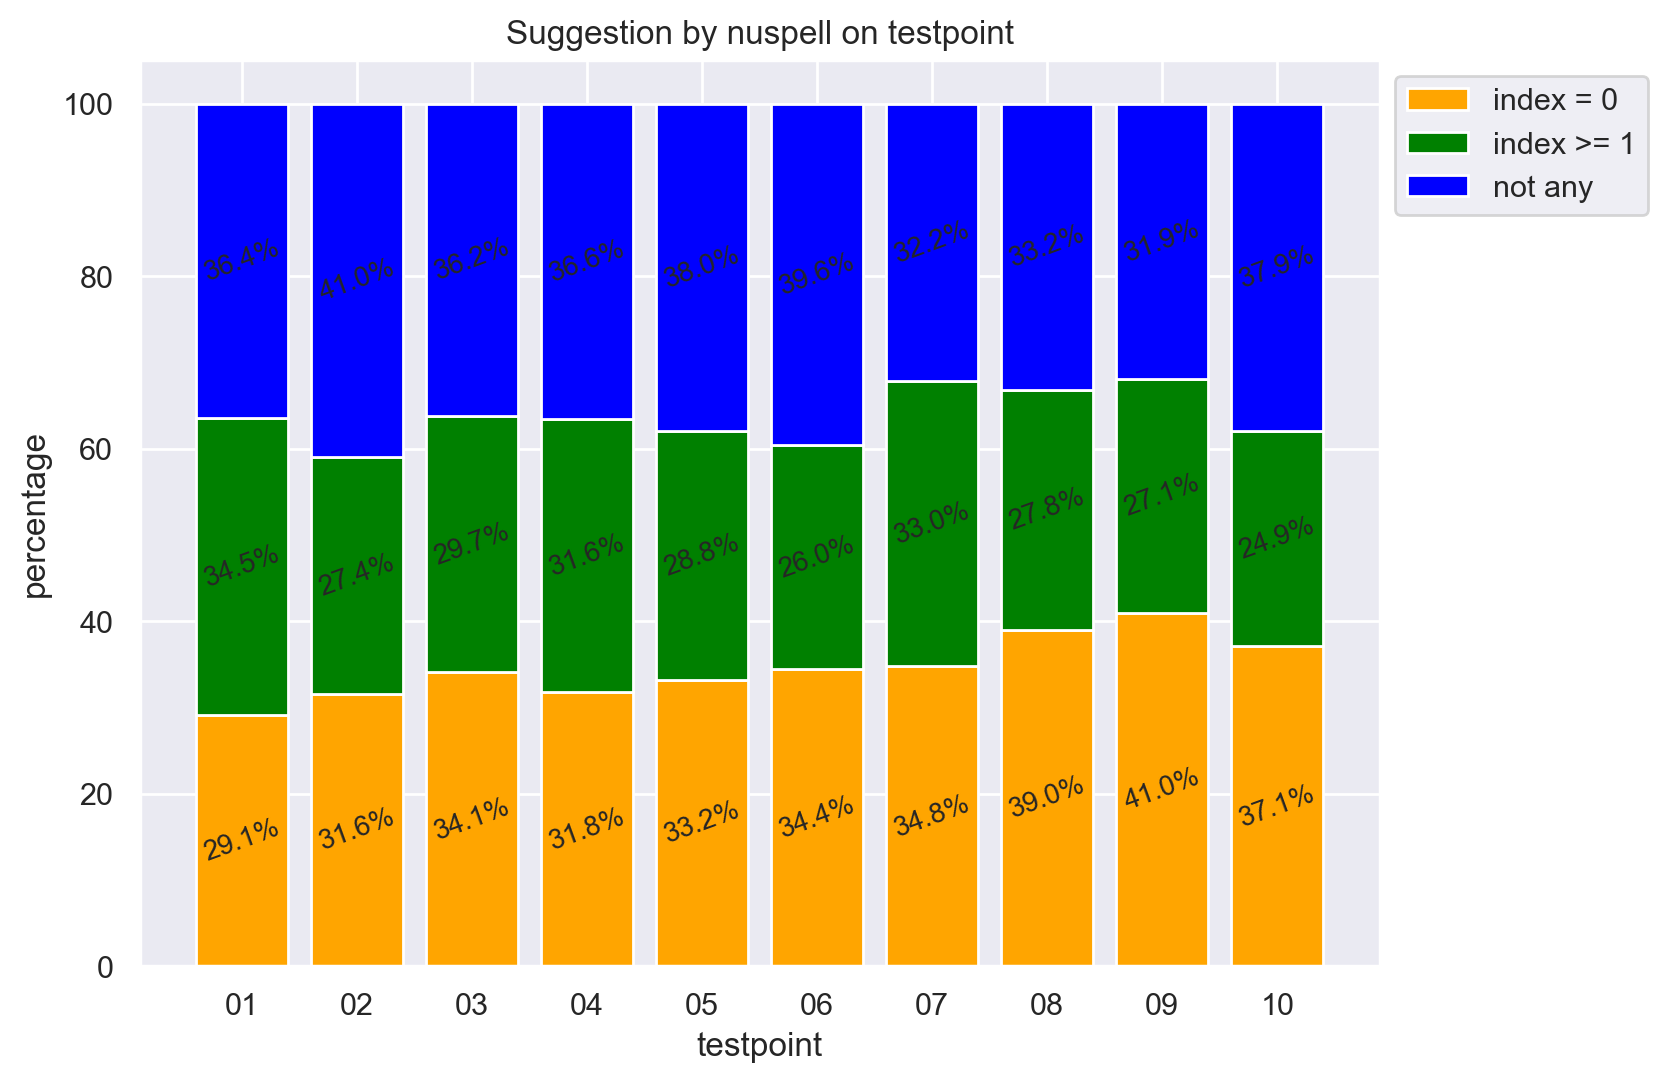

In [58]:
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = suggs_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)
# Create bars
axs.bar(x_pos, bars_sugg_0, bottom = 0, color='orange', label='index = 0') # index 0
axs.bar(x_pos, bars_sugg_1, bottom=bars_sugg_0, color='green', label='index >= 1') # index 1
axs.bar(x_pos, bars_sugg_non, bottom=[i+j for i, j in zip(bars_sugg_0,bars_sugg_1)], color='blue', label='not any') # noty any

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages
for idx, (ct_ttl, pct_non, pct_0, pct_1) in enumerate(zip(suggs_total, bars_sugg_non, bars_sugg_0, bars_sugg_1)):
    axs.text(idx, bars_sugg_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_sugg_0[idx]+(bars_sugg_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_sugg_0[idx]+bars_sugg_1[idx]+(bars_sugg_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)

# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Suggestion by nuspell on testpoint')

plt.show()

In [59]:
# Get averages for testpoints 1-5 and 6-10
# Shares ordered by appereance in plot
shares = [bars_sugg_0, bars_sugg_1, bars_sugg_non]
helpers.print_AM_half_tp(shares)

31.96
37.28
********************
30.39
27.77
********************
37.65
34.95
********************


### Relationship: Levenshtein distance on testpoint
- Percent stacked bar plot

#### Get Levenshtein distance stats

In [60]:
from nltk.metrics.distance import edit_distance

data_error_types['edit_dst'] = data_error_types.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)
data_error_token['edit_dst'] = data_error_token.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)

In [62]:
# Map them to edit distance 1 for plotting of Levenshtein distance stats
data_error_token['edit_dst_0excl'] = data_error_token.edit_dst.apply(lambda x: 1 if x == 0 else x)
data_error_types['edit_dst_0excl'] = data_error_types.edit_dst.apply(lambda x: 1 if x == 0 else x)
#display(data_error_token[data_error_token['edit_dst_0excl']==0])
#display(data_error_types[data_error_types['edit_dst_0excl']==0])

In [63]:
# Map values above 4 to 4 to summarize categories with few counts
data_error_token['edit_dst_4'] = data_error_token.edit_dst_0excl.apply(lambda x: 4 if x in [5,6,7,8,9] else x)
data_error_types['edit_dst_4'] = data_error_types.edit_dst_0excl.apply(lambda x: 4 if x in [5,6,7,8,9] else x)
#data_error_token.head(10)

#### - Percent stacked bar plot

In [64]:
# Count of tokens for each category (1; 2; 3; 4)
ct_dst_1 = data_error_token[data_error_token.edit_dst_4==1].groupby('testpoint').count().reset_index() # returns index, not testpoint as index
#display(ct_dst_1)
ct_dst_2 = data_error_token[data_error_token.edit_dst_4==2].groupby('testpoint').count().reset_index()
#display(ct_dst_2)
ct_dst_3 = data_error_token[data_error_token.edit_dst_4==3].groupby('testpoint').count().reset_index()
#display(ct_dst_3)
ct_dst_4 = data_error_token[data_error_token.edit_dst_4==4].groupby('testpoint').count().reset_index()
#display(ct_dst_4)

In [43]:
# Get total, i. e. count for 100%
ct_dst_total = [i+j+k+l for i,j,k,l in zip(ct_dst_1['edit_dst_4'], ct_dst_2['edit_dst_4'], ct_dst_3['edit_dst_4'], ct_dst_4['edit_dst_4'])] # list comprehension

#display(ct_dst_total)

# Get ratio of respective bars in percent, i. e. bar "length"
ratio_dst_1 = [i / j * 100 for i, j in zip(ct_dst_1['edit_dst_4'], ct_dst_total)]
ratio_dst_2 = [i / j * 100 for i, j in zip(ct_dst_2['edit_dst_4'], ct_dst_total)]
ratio_dst_3 = [i / j * 100 for i, j in zip(ct_dst_3['edit_dst_4'], ct_dst_total)]
ratio_dst_4 = [i / j * 100 for i, j in zip(ct_dst_4['edit_dst_4'], ct_dst_total)]

#display(ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4)

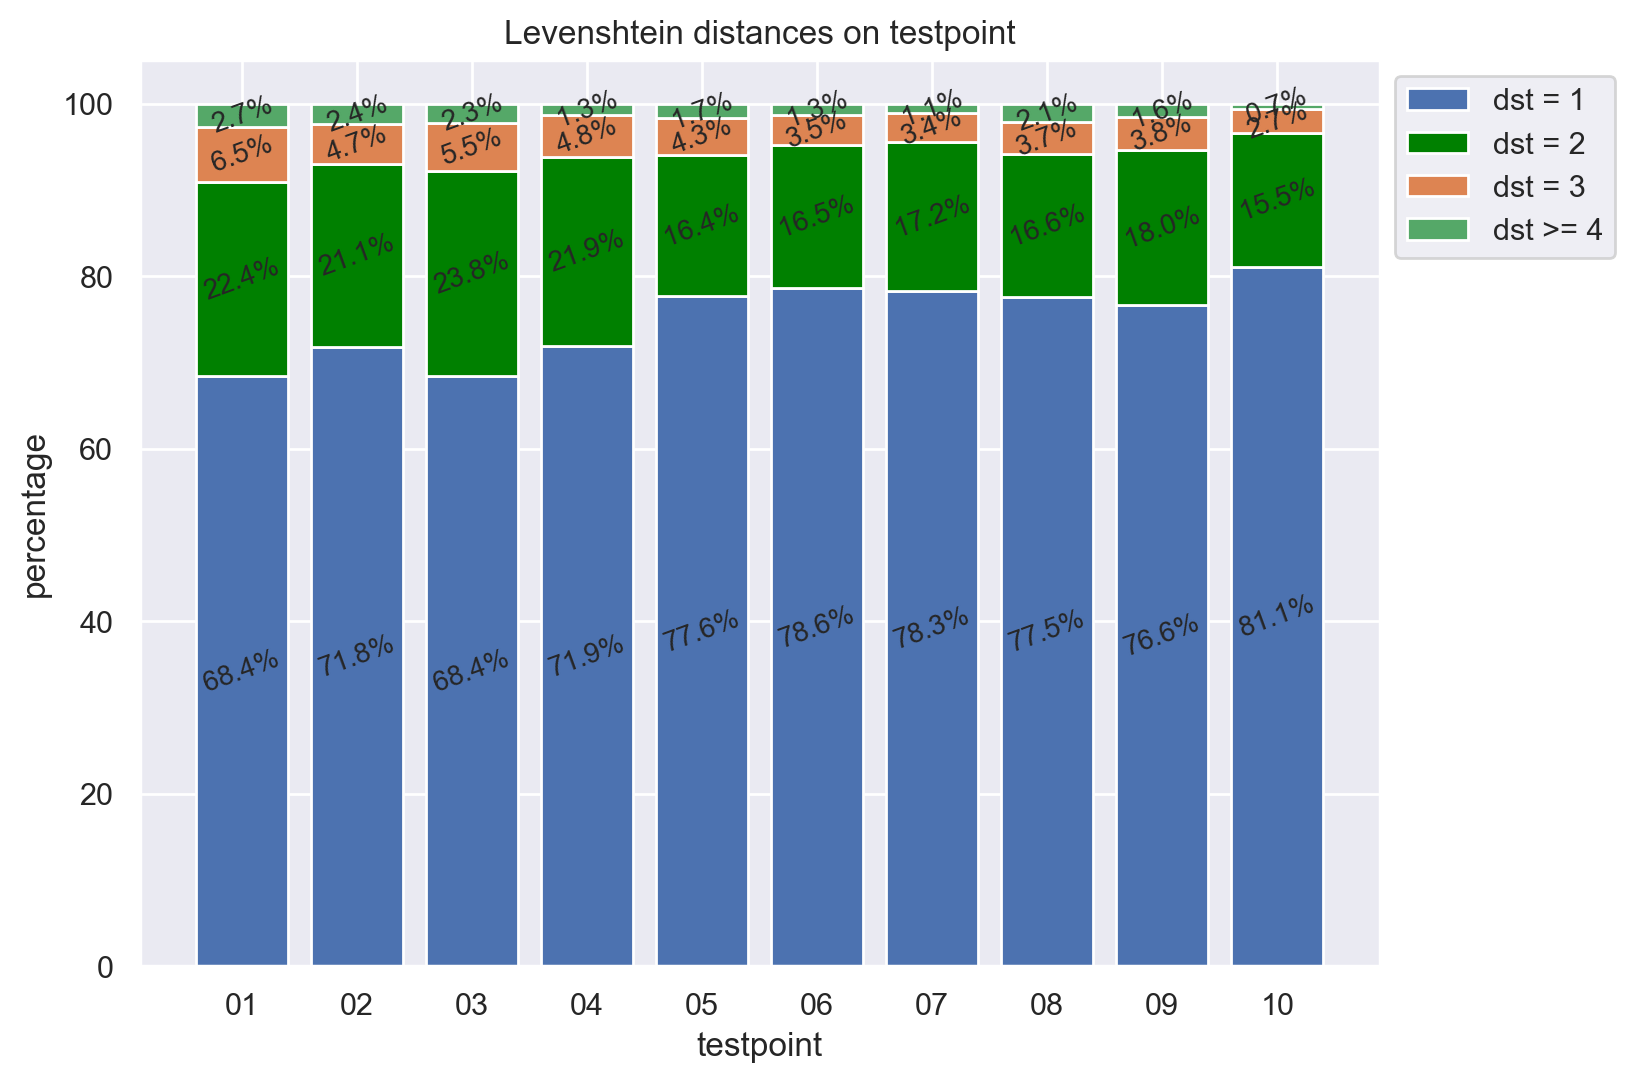

In [65]:
# TODO: Rule of three: Percent stacked bar plot over testpoints as function
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = suggs_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)

# Create bars; Modify
axs.bar(x_pos, ratio_dst_1, bottom = 0, label='dst = 1') # index 0
axs.bar(x_pos, ratio_dst_2, bottom = ratio_dst_1, color='green', label='dst = 2') # index 1
axs.bar(x_pos, ratio_dst_3, bottom=[i+j for i, j in zip(ratio_dst_1,ratio_dst_2)], label='dst = 3') # noty any
axs.bar(x_pos, ratio_dst_4, bottom=[i+j+k for i, j, k in zip(ratio_dst_1,ratio_dst_2,ratio_dst_3)], label='dst >= 4') # noty any

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages; Modify
for idx, (ct_ttl, rt_1, rt_2, rt_3, rt_4) in enumerate(zip(ct_dst_total, ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4)):
    axs.text(idx, ratio_dst_1[idx]/2, str(round(rt_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+(ratio_dst_2[idx]/2), str(round(rt_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+ratio_dst_2[idx]+(ratio_dst_3[idx]/2), str(round(rt_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+ratio_dst_2[idx]+ratio_dst_3[idx]+(ratio_dst_4[idx]/2), str(round(rt_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
                                                       
# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Levenshtein distances on testpoint')

plt.show()

In [66]:
ratios_dst = [ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4]
helpers.print_AM_half_tp(ratios_dst)

71.64
78.44
********************
21.12
16.77
********************
5.16
3.43
********************
2.08
1.36
********************


<a id='7'></a><br>
### Relationship: Suggestions index on Levenshtein distance
- Percent stacked bar plot

#### - Percent stacked bar plot

In [67]:
def get_count_zero(x, gb_var='edit_dst_4'):
    grouped = data_error_token[data_error_token.sugg_idx_5==x].groupby(gb_var).count()
    # From edit-distance 2 on, there are zero values for the categories (index of suggestions) that are not counted by count
    # Therefore zero counts have to be added manually
    added_zero_values = grouped.reindex(data_error_token.edit_dst_4.unique()).fillna(0).astype(int)
    return added_zero_values.reset_index()

In [68]:
# TODO: Modularize
# 1) Get counts for each category (-1; 0; 1; 2; 3; 4; 5)
# Function see above
ct_non = get_count_zero(-1, gb_var='edit_dst_4')
ct_0 = get_count_zero(0.0, gb_var='edit_dst_4')
ct_1 = get_count_zero(1.0, gb_var='edit_dst_4')
ct_2 = get_count_zero(2.0, gb_var='edit_dst_4')
ct_3 = get_count_zero(3.0, gb_var='edit_dst_4')
ct_4 = get_count_zero(4.0, gb_var='edit_dst_4')
ct_5 = get_count_zero(5.0, gb_var='edit_dst_4')
#display(ct_non)

In [69]:
# 2) Get total, i. e. count for 100%
ct_total_2 = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(ct_non['sugg_idx_5'], ct_0['sugg_idx_5'], ct_1['sugg_idx_5'],
                                                   ct_2['sugg_idx_5'], ct_3['sugg_idx_5'], ct_4['sugg_idx_5'], ct_5['sugg_idx_5'])]
#display(ct_total_2)

In [70]:
# 3) Get ratio of respective bars in percent, i. e. bar "length"
bars_ct_non = [i / j * 100 for i, j in zip(ct_non['sugg_idx_5'], ct_total_2)]
bars_ct_0 = [i / j * 100 for i, j in zip(ct_0['sugg_idx_5'], ct_total_2)]
bars_ct_1 = [i / j * 100 for i, j in zip(ct_1['sugg_idx_5'], ct_total_2)]
bars_ct_2 = [i / j * 100 for i, j in zip(ct_2['sugg_idx_5'], ct_total_2)]
bars_ct_3 = [i / j * 100 for i, j in zip(ct_3['sugg_idx_5'], ct_total_2)]
bars_ct_4 = [i / j * 100 for i, j in zip(ct_4['sugg_idx_5'], ct_total_2)]
bars_ct_5 = [i / j * 100 for i, j in zip(ct_5['sugg_idx_5'], ct_total_2)]
#display(bars_ct_non)

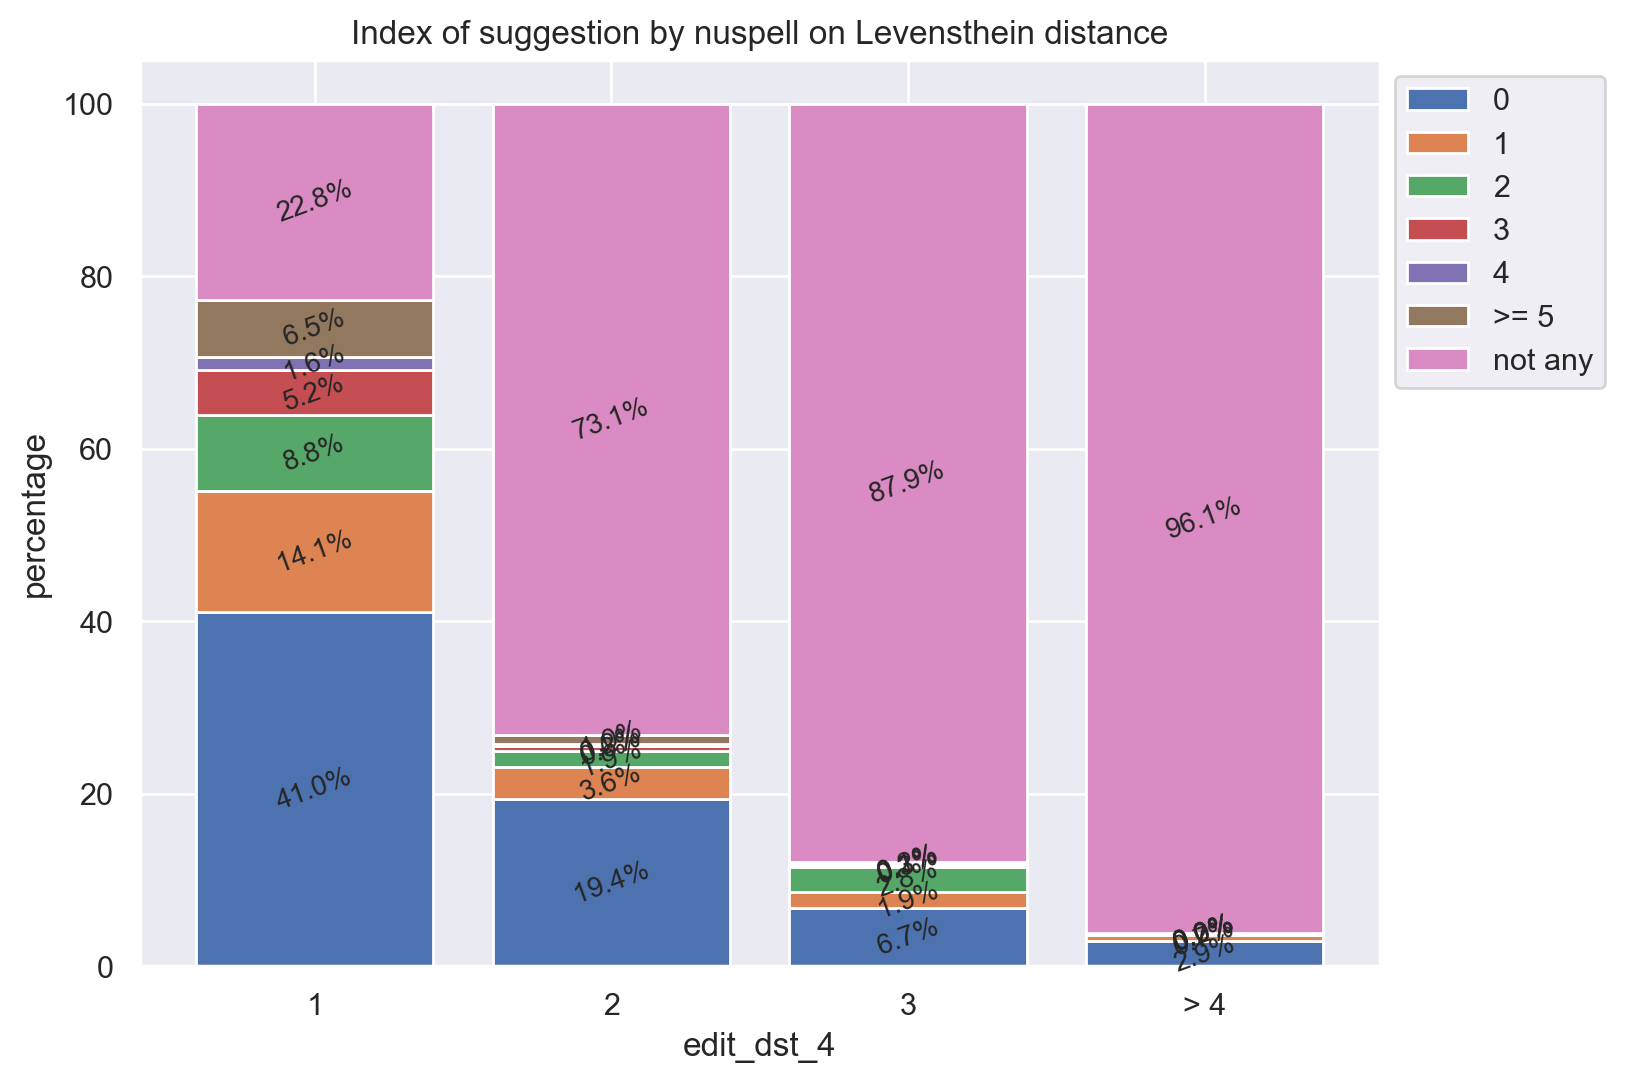

In [71]:
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,4) # position of x-ticks
#x_lab = ct_non['edit_dst_4']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)

# Create bars
axs.bar(x_pos, bars_ct_0, bottom = 0, label='0') # index 0
axs.bar(x_pos, bars_ct_1, bottom=bars_ct_0, label='1') # index 1
axs.bar(x_pos, bars_ct_2, bottom=[i+j for i, j in zip(bars_ct_0,bars_ct_1)], label='2') 
axs.bar(x_pos, bars_ct_3, bottom=[i+j+k for i, j, k in zip(bars_ct_0,bars_ct_1, bars_ct_2)], label='3') 
axs.bar(x_pos, bars_ct_4, bottom=[i+j+k+l for i, j, k, l in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3)], label='4')
axs.bar(x_pos, bars_ct_5, bottom=[i+j+k+l+m for i, j, k, l, m in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4)], label='>= 5')
axs.bar(x_pos, bars_ct_non, bottom=[i+j+k+l+m+n for i, j, k, l, m, n in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)], label='not any')

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(['1','2','3','> 4'])
axs.set_xlabel('edit_dst_4')

axs.set_ylabel('percentage')

# Plot percentages
for idx, (ct_ttl, pct_non, pct_0, pct_1, pct_2, pct_3, pct_4, pct_5) in enumerate(zip(ct_total_2, bars_ct_non, bars_ct_0, bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)):
    axs.text(idx, bars_ct_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+(bars_ct_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+(bars_ct_2[idx]/2), str(round(pct_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+(bars_ct_3[idx]/2), str(round(pct_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+(bars_ct_4[idx]/2), str(round(pct_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+(bars_ct_5[idx]/2), str(round(pct_5,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+bars_ct_5[idx]+(bars_ct_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    
# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Index of suggestion by nuspell on Levensthein distance')

plt.show()